# Task 2

Perform hyper-parameter tuning on the DecisionTree algorithm in order to predict the target column "outcome" for the status of each horse in the dataset. Use 5-fold cross-validation for the hyper-parameter tuning, tune the parameters "criterion", "max_depth", and "min_samples_split". Provide at least 3 values for each parameter.

## Dataset description

### Features

* id - horse identifier
* surgery - was the horse in surgery (0 - no, 1 - yes)
* age - if the horse is young or old (0 - old, 1 - young)
* hospital_number - the identifier of the hospital the horse was treated in
* rectal_temp - the horse's rectal temperature
* respiratory_rate - the horse's respiratory rate
* temp_of_extremities - the horse's temperature of the extremities (represented as categories ordered by intensity)
* pulse - the horse's pulse
* nasogastric_reflux_ph - ph value of the horse's nasogastric reflux
* packed_cell_volume - volume of horse's packed cell
* total_protein - horse's total protein value
* abdomo_protein - horse's abdominal protein value
* surgical_lesion - whether the horse has a surgical lesion or not
* lesion_1 - size of the lesion (0 if the horse doesn't have one)
* cp_data - binary variable

### Target variable
outcome

### Download the dataset

In [561]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('data_train.csv')

In [562]:
df.sample(5)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgical_lesion,lesion_1,cp_data,outcome
558,558,1,0,529796,37.6,88.0,48.0,2,6.5,48.0,4.5,3.4,1,3205,1,died
686,686,1,0,533836,39.2,98.0,28.0,1,2.0,65.0,64.0,2.0,1,2205,0,lived
494,494,1,0,5287179,38.3,88.0,28.0,3,4.5,48.0,6.1,2.6,1,5206,0,died
865,865,1,0,527463,37.1,84.0,48.0,3,5.0,72.0,6.6,3.2,1,2208,0,died
81,81,0,0,535415,38.0,146.0,36.0,2,2.0,57.0,66.0,2.0,1,3205,1,euthanized


In [563]:
df_copy = df.copy()
df_copy.isnull().sum()

id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
nasogastric_reflux_ph    0
packed_cell_volume       0
total_protein            0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
cp_data                  0
outcome                  0
dtype: int64

In [565]:
df_copy = df_copy.drop(['id', 'hospital_number'], axis=1)
df_copy.describe()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgical_lesion,lesion_1,cp_data
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,0.718219,0.060729,38.202186,79.574089,30.054251,2.183806,4.382591,49.602429,21.388016,3.290931,0.752227,3832.496356,0.540891
std,0.450050,0.238929,0.788668,29.108638,16.452066,0.786472,1.937357,10.535800,26.676453,1.589195,0.431894,5436.733774,0.498527
min,0.000000,0.000000,35.400000,30.000000,8.000000,0.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,37.800000,53.000000,18.000000,2.000000,2.000000,43.000000,6.600000,2.000000,1.000000,2205.000000,0.000000
50%,1.000000,0.000000,38.200000,76.000000,28.000000,2.000000,4.500000,48.000000,7.500000,3.000000,1.000000,2209.000000,1.000000
75%,1.000000,0.000000,38.600000,100.000000,36.000000,3.000000,6.000000,57.000000,9.100000,4.300000,1.000000,3205.000000,1.000000
max,1.000000,1.000000,40.800000,184.000000,96.000000,4.000000,7.500000,75.000000,89.000000,10.100000,1.000000,41110.000000,1.000000


In [566]:
df_copy['outcome'].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

In [570]:
# sns.pairplot(df_copy)

In [572]:
encoder = LabelEncoder()
df_copy['outcome'] = encoder.fit_transform(df_copy['outcome'])
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   int64  
 1   age                    1235 non-null   int64  
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   int64  
 6   nasogastric_reflux_ph  1235 non-null   float64
 7   packed_cell_volume     1235 non-null   float64
 8   total_protein          1235 non-null   float64
 9   abdomo_protein         1235 non-null   float64
 10  surgical_lesion        1235 non-null   int64  
 11  lesion_1               1235 non-null   int64  
 12  cp_data                1235 non-null   int64  
 13  outcome                1235 non-null   int32  
dtypes: float64(7), int32(1), int64(6)
memory usage: 130.4 KB

In [574]:
from sklearn.model_selection import train_test_split
X = df_copy.drop(['outcome'],axis=1)
Y = df_copy['outcome']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

array([[<Axes: title={'center': 'surgery'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'rectal_temp'}>,
        <Axes: title={'center': 'pulse'}>],
       [<Axes: title={'center': 'respiratory_rate'}>,
        <Axes: title={'center': 'temp_of_extremities'}>,
        <Axes: title={'center': 'nasogastric_reflux_ph'}>,
        <Axes: title={'center': 'packed_cell_volume'}>],
       [<Axes: title={'center': 'total_protein'}>,
        <Axes: title={'center': 'abdomo_protein'}>,
        <Axes: title={'center': 'surgical_lesion'}>,
        <Axes: title={'center': 'lesion_1'}>],
       [<Axes: title={'center': 'cp_data'}>,
        <Axes: title={'center': 'outcome'}>, <Axes: >, <Axes: >]],
      dtype=object)

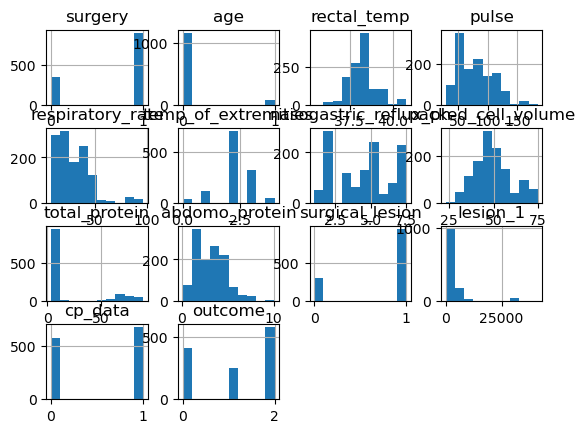

In [575]:
df_copy.hist()

In [577]:
scaler = StandardScaler()
minMaxScaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [579]:
model = DecisionTreeClassifier()

In [580]:
rkf = RepeatedKFold(n_splits=5)
rkf.get_n_splits(X, Y)

50

In [582]:
param_grid ={
    'criterion':["gini", "entropy", "log_loss"],
    'max_depth': [10,15,20,25],
    'min_samples_split': [4,8,12],
    'class_weight' : ['balanced', None]
}

In [583]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=rkf)

In [584]:
grid_search.fit(X,Y)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15, 20, 25],
                         'min_samples_split': [4, 8, 12]})

In [585]:
grid_search.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 12}

In [586]:
cv.best_score_

0.6075890888581243

In [587]:
model = cv.best_estimator_

In [588]:
y_pred = model.predict(X_test)

In [589]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(Y_test,y_pred)

0.7732793522267206

In [590]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        79
           1       0.80      0.67      0.73        54
           2       0.81      0.81      0.81       114

    accuracy                           0.77       247
   macro avg       0.77      0.76      0.76       247
weighted avg       0.78      0.77      0.77       247



In [591]:
#XGBoost

In [592]:
model = XGBClassifier()


In [593]:
param_grid = {
    'learning_rate' :[0.01, 0.05, 0.1, 0.2],
    'colsample_bylevel': [0.6,0.7,0.8],
    'max_depth' :[10,8,15],
    'n_estimators' : [100,200,500]
}


In [594]:
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [595]:
y_pred = model.predict(X_test)

In [596]:
accuracy_score(Y_test,y_pred)

0.6518218623481782

In [597]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.65      0.62        79
           1       0.68      0.50      0.57        54
           2       0.68      0.73      0.70       114

    accuracy                           0.65       247
   macro avg       0.65      0.62      0.63       247
weighted avg       0.65      0.65      0.65       247

